# Import appropriate modules

In [174]:
import numpy as np
from numpy.linalg import eigh
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants

import matplotlib.pyplot as plt
import matplotlib.colors

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

import itertools

#plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Define 'global' Constants

In [176]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=2

I = 0 #W/m^2
E = 0 #V/m

GAUSS = 1e4 # T
B_MIN = 0.01 / GAUSS # T
B_MAX = 350 / GAUSS # T
B_STEPS = 350

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T

def btoi(b):
    return (b-B_MIN)/B_STEP_SIZE

def itob(i):
    return B_STEP_SIZE*i+B_MIN

# Build and Diagonalise Hamiltonian for many B

In [177]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, Rb87Cs133, zeeman=True, Edc=True, ac=True)

H = H0[..., None]+\
    Hz[..., None]*B+\
    Hdc[..., None]*E+\
    Hac[..., None]*I
H = H.transpose(2,0,1)

ENERGIES_UNSORTED, STATES_UNSORTED = eigh(H)

In [178]:
# ENERGIES_HALF_SORTED, STATES_HALF_SORTED = calculate.sort_smooth(ENERGIES_UNSORTED,STATES_UNSORTED)
ENERGIES, STATES, LABELS = calculate.sort_by_state(ENERGIES_UNSORTED, STATES_UNSORTED, N_MAX, Rb87Cs133)

In [179]:
MAGNETIC_MOMENTS = calculate.magnetic_moment(STATES, N_MAX, Rb87Cs133)

# Helper Functions

In [61]:
def label_to_state_no(N,MF,k):
    for i, label in enumerate(LABELS):
        if label[0] == N and label[1] == MF and label[2] == k:
            return i

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = int(I1*2)
    I2d = int(I2*2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1
    
print(label_to_state_no(*(2, 4, 13)))

None


# General Constants

In [7]:
INITIAL_STATE_LABEL = (0,5,0)
INITIAL_STATE_POSITION = label_to_state_no(*INITIAL_STATE_LABEL)

# Ordered by energy low->high at 181.5G 
ACCESSIBLE_STATE_LABELS = [(1, 5, 0), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 5, 1), (1, 4, 2), (1, 5, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5)]
ACCESSIBLE_STATE_POSITIONS = [label_to_state_no(N,MF,k) for N,MF,k in ACCESSIBLE_STATE_LABELS]

CONSIDERED_STATE_LABELS = [INITIAL_STATE_LABEL] + ACCESSIBLE_STATE_LABELS
CONSIDERED_STATE_POSITIONS = [INITIAL_STATE_POSITION] + ACCESSIBLE_STATE_POSITIONS

STATE_CMAP = plt.cm.gist_rainbow(np.linspace(0,1,len(CONSIDERED_STATE_POSITIONS)))

# Debug sort function Find Magnetic Moments

Text(0.5, 0, 'Magnetic Field $B_z$ (G)')

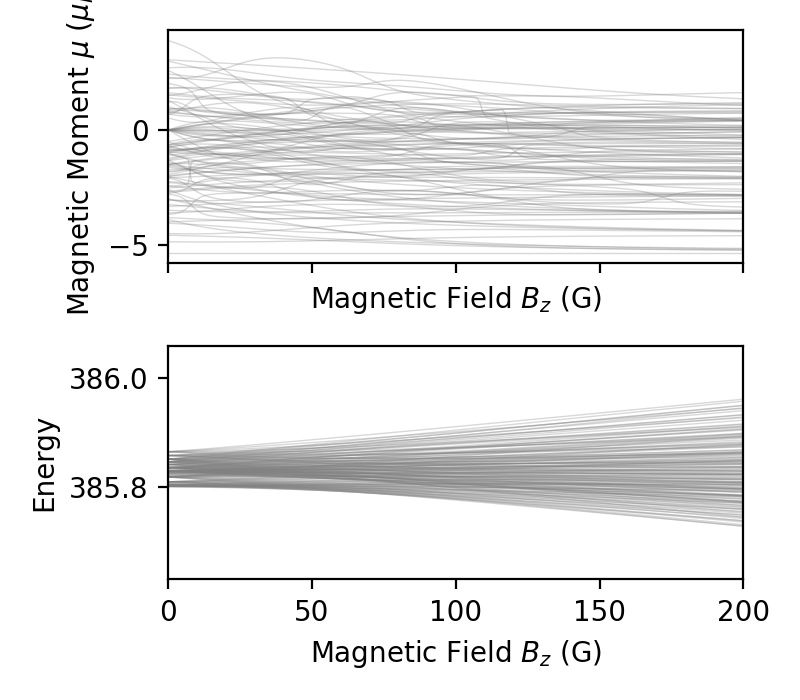

In [180]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
muN = scipy.constants.physical_constants['nuclear magneton'][0]

ax1.plot(B*GAUSS,MAGNETIC_MOMENTS[:,180:]/muN, color='grey', alpha=0.3,linewidth=0.5,zorder=0);
ax1.set_xlim(0,200)
ax1.set_ylabel("Magnetic Moment $\mu$ $(\mu_N)$")
ax1.set_xlabel("Magnetic Field $B_z$ (G)")

ax2.plot(B*GAUSS,ENERGIES[:,128:]/muN, color='grey', alpha=0.3,linewidth=0.5,zorder=0);
ax2.set_xlim(0,200)
ax2.set_ylabel("Energy")
ax2.set_xlabel("Magnetic Field $B_z$ (G)")



# Find Coindidences

In [73]:
def label_degeneracy(N,MF):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1 in range(-int(I1+0.5),int(I1+0.5)+1):
            M_I1 = M_I1-0.5
            for M_I2 in range(-int(I2+0.5),int(I2+0.5)+1):
                M_I2 = M_I2-0.5
                if MN+M_I1+M_I2 == MF:
                    d+=1
    return d

print(label_degeneracy(0,5))
print(label_degeneracy(1,4))
print(label_degeneracy(1,5))
print(label_degeneracy(1,6))
print(label_degeneracy(1,7))

1
6
3
1
0


In [184]:
# Find all possible combinations
base_mf = 4
polarisations = []
for p1 in [-1,0,1]:
    for p2 in [-1,0,1]:
        for p3 in [-1,0,1]:
            for p4 in [-1,0,1]:
                if p1+p2+p3+p4 == 0:
                    polarisations.append((p1,p2,p3,p4))

state_mfs = [(base_mf,base_mf+p1,base_mf+p1+p2,base_mf+p1+p2+p3) for p1,p2,p3,_ in polarisations]

states = []

for state_mf in state_mfs:
    for i in [1]:
        for j in range(label_degeneracy(1,state_mf[1])):
            for k in range(label_degeneracy(2,state_mf[2])):
                for l in range(label_degeneracy(1,state_mf[3])):
                    if (state_mf[1]<state_mf[3]) or (state_mf[1]==state_mf[3] and j<=l):
                        continue
                    states.append([(0,state_mf[0],i),(1,state_mf[1],j),(2,state_mf[2],k),(1,state_mf[3],l)])
                    
print(len(states), "states to consider")

4014 states to consider


In [185]:
ranking = []
where = []
for state_posibility in states:
    #Want to minimise sum of differences^2
    diff_total=np.zeros(B_STEPS,dtype=np.double)

    for state_a, state_b in itertools.combinations(state_posibility,2):
        state_a_num=label_to_state_no(*state_a)
        state_b_num=label_to_state_no(*state_b)
        if state_a_num==None or state_b_num==None:
            #print(state_a,"or",state_b, "could not be found in basis")
            diff_total += 20*np.ones((B_STEPS))
        else:
            diff = np.abs(MAGNETIC_MOMENTS[:,state_a_num]-MAGNETIC_MOMENTS[:,state_b_num])**2
            diff_total += diff
        #xs = (B[sign_flip_low_indices] + B[sign_flip_low_indices+1])*GAUSS/2
        #ys = (moment_a[sign_flip_low_indices]+moment_a[sign_flip_low_indices+1])/(2*muN)
        # ax.scatter(xs, ys,color='k',s=0.4,zorder=1)
    min_diff_loc = np.argmin(diff_total, axis=0)
    min_diff = diff_total[min_diff_loc]
    
    where.append(min_diff_loc)
    ranking.append(min_diff)

ranking=np.array(ranking)
order = ranking.argsort()

where_interesting = np.array(where)[order]
interesting_states = np.array(states)[order]

Text(0.009, 0.5, 'Magnetic Moment $\\mu$ $(\\mu_N)$')

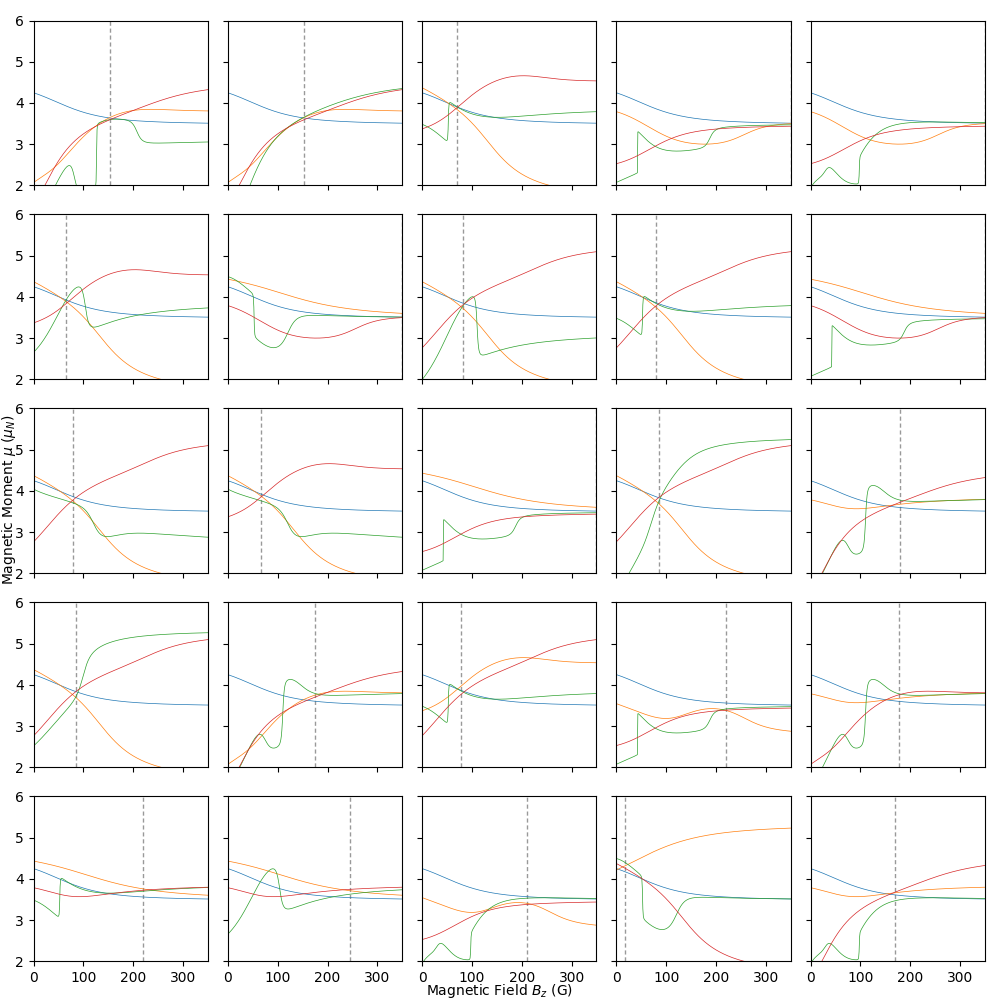

In [186]:
fig, axs = plt.subplots(5,5,figsize=(10,10),dpi=100,sharex=True,sharey=True)

i=0
for axh in axs:
    for ax in axh:
        state_numbers = np.array([label_to_state_no(*state_label) for state_label in interesting_states[i]])
        ax.set_xlim(0,B_MAX*GAUSS)
        ax.set_ylim(2,6)
        ax.plot(B*GAUSS,MAGNETIC_MOMENTS[:,state_numbers]/muN, alpha=1,linewidth=0.5,zorder=1);
        ax.axvline(x=B[where_interesting[i]]*GAUSS, dashes=(3, 2), color='k', linewidth=1,alpha=0.4,zorder=0)
        i+=1

fig.text(0.5, 0.009, 'Magnetic Field $B_z$ (G)', ha='center', va='center')
fig.text(0.009, 0.5, 'Magnetic Moment $\mu$ $(\mu_N)$', ha='center', va='center', rotation='vertical')

In [187]:
def transfer_efficiency(ai,bi):
    return 0.9

In [193]:
# Simulate microwave transfers to find 'fidelity'
focus_state = interesting_states[0]
p=1
for i in range(4):
    state_a_pos = label_to_state_no(*focus_state[i%4])
    state_b_pos = label_to_state_no(*focus_state[(i+1)%4])
    p *= transfer_efficiency(state_a_pos,state_b_pos)


0.6561000000000001
